In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns, converter_periodo
from src.optimization.markowitz import solve_markowitz
from outputs.charts.models_markowitz import compare_frontiers, compare_time_series

# Importar modelos
from src.models.lr_monthly import predict_monthly_lr
from src.models.rnn_monthly import predict_monthly_rnn
from src.models.ensemble import ensemble_predictions
from src.models.evaluate import evaluate_model_portfolio

In [2]:

tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date   = "2025-06-01"

prices = load_prices(tickers, start=start_date, end=end_date)

/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [3]:
returns_daily   = compute_returns(prices, freq="daily")
returns_monthly = compute_returns(prices, freq="monthly")

pure_monthly = returns_monthly.mean()
cov_monthly  = returns_monthly.cov()

print("Retorno médio mensal histórico:")
display(pure_monthly)
print("\nMatriz de Cov Mensal:")
display(cov_monthly)


Retorno médio mensal histórico:


Ticker
ABEV3.SA    0.003712
B3SA3.SA    0.015936
BBAS3.SA    0.015096
BBDC4.SA    0.008739
GGBR4.SA    0.014558
ITUB4.SA    0.013293
PETR4.SA    0.025864
VALE3.SA    0.014284
WEGE3.SA    0.024835
dtype: float64


Matriz de Cov Mensal:


Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Ticker,,,,,,,,,
ABEV3.SA,0.005055,0.003080,0.002513,0.003498,0.002501,0.002734,0.002668,0.001435,0.001314
B3SA3.SA,0.003080,0.010071,0.005028,0.006914,0.002685,0.005758,0.004736,0.000974,0.003189
BBAS3.SA,0.002513,0.005028,0.010274,0.006715,0.003300,0.006014,0.007976,0.000723,0.000407
BBDC4.SA,0.003498,0.006914,0.006715,0.009689,0.003626,0.007053,0.006110,0.001348,0.001555
GGBR4.SA,0.002501,0.002685,0.003300,0.003626,0.011161,0.003033,0.004412,0.005008,0.003770
ITUB4.SA,0.002734,0.005758,0.006014,0.007053,0.003033,0.007095,0.004953,0.001427,0.001935
PETR4.SA,0.002668,0.004736,0.007976,0.006110,0.004412,0.004953,0.011777,0.001627,0.000737
VALE3.SA,0.001435,0.000974,0.000723,0.001348,0.005008,0.001427,0.001627,0.006854,0.000700
WEGE3.SA,0.001314,0.003189,0.000407,0.001555,0.003770,0.001935,0.000737,0.000700,0.008317


In [4]:
print("\n Prevendo retorno mensal → LR ")
pred_lr_month = predict_monthly_lr(prices)
display(pred_lr_month)

print("\n Prevendo retorno mensal → RNN ")
pred_rnn_month = predict_monthly_rnn(prices)
display(pred_rnn_month)

print("\n Ensemble mensal ")
pred_ens_month = ensemble_predictions(
    pure_monthly, 
    pred_lr_month, 
    pred_rnn_month
)
display(pred_ens_month)



 Prevendo retorno mensal → LR 


ABEV3.SA    0.009160
B3SA3.SA    0.017472
BBAS3.SA    0.005076
BBDC4.SA    0.012453
GGBR4.SA    0.018430
ITUB4.SA    0.015937
PETR4.SA    0.027698
VALE3.SA    0.018135
WEGE3.SA    0.018526
Name: LR_Monthly_Prediction, dtype: float64


 Prevendo retorno mensal → RNN 


ABEV3.SA    0.006215
B3SA3.SA    0.016889
BBAS3.SA    0.010862
BBDC4.SA    0.010712
GGBR4.SA    0.014985
ITUB4.SA    0.014999
PETR4.SA    0.029474
VALE3.SA    0.009705
WEGE3.SA    0.016839
Name: RNN_Monthly_Prediction, dtype: float64


 Ensemble mensal 


Ticker
ABEV3.SA    0.005449
B3SA3.SA    0.016463
BBAS3.SA    0.011956
BBDC4.SA    0.009964
GGBR4.SA    0.015590
ITUB4.SA    0.014210
PETR4.SA    0.026864
VALE3.SA    0.014560
WEGE3.SA    0.022058
dtype: float64

In [5]:
lamb = 0.5

w_pure = solve_markowitz(pure_monthly, cov_monthly, lamb=lamb)
w_lr   = solve_markowitz(pred_lr_month, cov_monthly, lamb=lamb)
w_rnn  = solve_markowitz(pred_rnn_month, cov_monthly, lamb=lamb)
w_ens  = solve_markowitz(pred_ens_month, cov_monthly, lamb=lamb)

df_weights = pd.DataFrame({
    "Ticker": tickers,
    "Puro": w_pure,
    "LR": w_lr,
    "RNN": w_rnn,
    "Ensemble": w_ens
})

display(df_weights)

,Ticker,Puro,LR,RNN,Ensemble
0,PETR4.SA,1.340413e-01,0.203305,2.013978e-01,1.711902e-01
1,VALE3.SA,0.000000e+00,0.004602,7.277707e-18,0.000000e+00
2,ITUB4.SA,9.984141e-02,0.000000,8.673081e-03,4.282597e-02
3,BBDC4.SA,2.602085e-18,0.000000,7.087972e-18,0.000000e+00
4,BBAS3.SA,2.818926e-18,0.000000,2.156207e-17,6.764066e-17
5,ABEV3.SA,3.676517e-04,0.071801,6.913349e-02,5.049426e-02
6,WEGE3.SA,1.283149e-01,0.156375,1.779199e-01,1.427536e-01
7,B3SA3.SA,2.989335e-01,0.307690,2.647119e-01,2.917565e-01
8,GGBR4.SA,3.385012e-01,0.256226,2.781638e-01,3.009795e-01


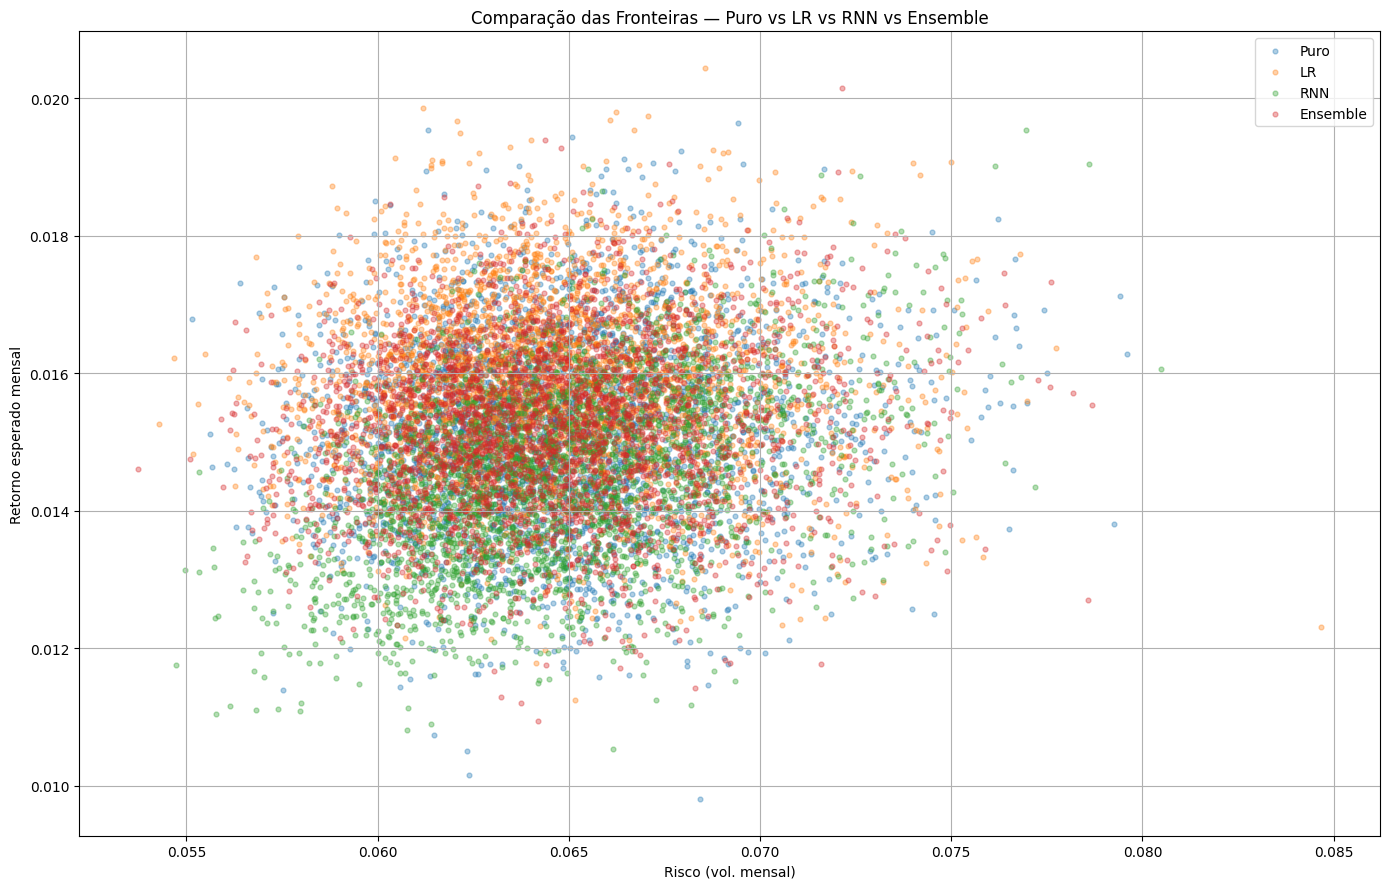

In [6]:

compare_frontiers(
    pure_monthly,
    pred_lr_month,
    pred_rnn_month,
    pred_ens_month,
    cov_monthly
)

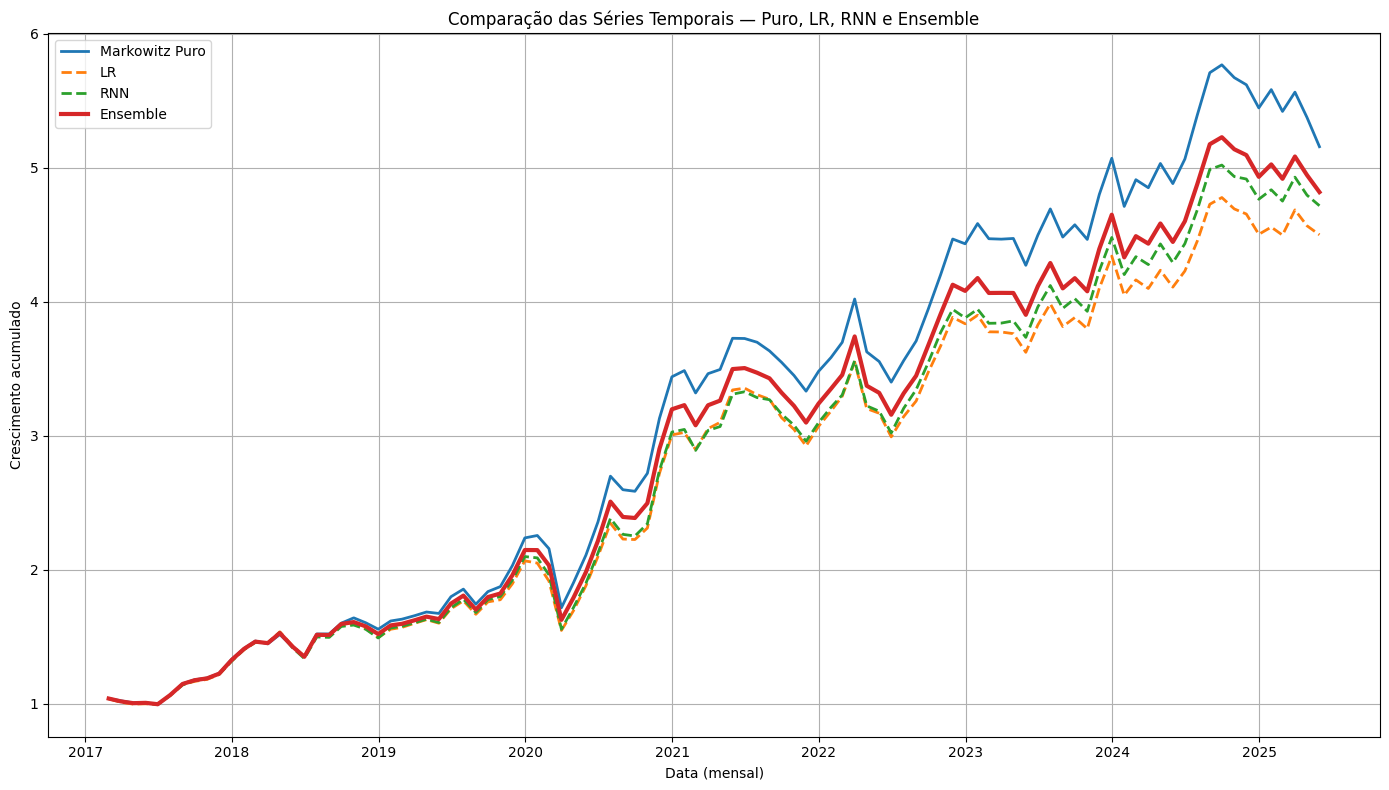

In [7]:

compare_time_series(
    returns_monthly,
    pure_monthly,
    pred_lr_month,
    pred_rnn_month,
    pred_ens_month,
    cov_monthly
)

In [8]:

eval_pure = evaluate_model_portfolio(returns_monthly, pure_monthly, cov_monthly, "Puro")
eval_lr   = evaluate_model_portfolio(returns_monthly, pred_lr_month, cov_monthly, "LR")
eval_rnn  = evaluate_model_portfolio(returns_monthly, pred_rnn_month, cov_monthly, "RNN")
eval_ens  = evaluate_model_portfolio(returns_monthly, pred_ens_month, cov_monthly, "Ensemble")

df_eval = pd.concat([eval_pure, eval_lr, eval_rnn, eval_ens])
display(df_eval)

,Modelo,Retorno Anual,Vol Anual,Sharpe,Max Drawdown (proxy)
0,Puro,0.216060,0.188256,1.147692,1.913613
0,LR,0.199024,0.186311,1.068233,1.717490
0,RNN,0.205062,0.187432,1.094065,1.770491
0,Ensemble,0.207451,0.186590,1.111801,1.808517
